# Fractions of ploidy levels in hepatocytes

## Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import mixture

%load_ext rpy2.ipython

In [2]:
%R require(ggplot2)

R[write to console]: Loading required package: ggplot2



array([1], dtype=int32)

In [3]:
def calc_mode(data, eval_N = 10000):
    eval_sizes = np.linspace(np.min(data), np.max(data), eval_N)
    return eval_sizes[np.argmax(sp.stats.gaussian_kde(data)(eval_sizes))]

## Reading the data

In [4]:
nuclei = pd.read_excel('../../../data/Nuclei_diameters+calculated_volumes.xlsx', usecols=np.arange(7))
nuclei = pd.melt(nuclei, var_name='sample', value_name='diameter').dropna()

nuclei['volume'] = 4/3*np.pi*(nuclei['diameter']/2)**3

In [5]:
nuclei.head()

,sample,diameter,volume
0,HL#3,7.7,239.040120
1,HL#3,6.4,137.258277
2,HL#3,11.0,696.909970
3,HL#3,7.6,229.847296
4,HL#3,8.1,278.261857


## EDA

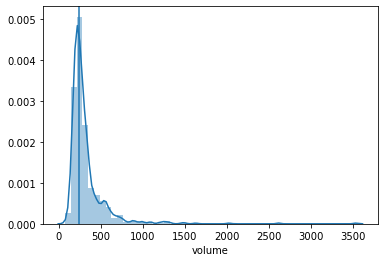

In [6]:
sns.distplot(nuclei['volume'])
plt.axvline(calc_mode(nuclei['volume']))
plt.show()

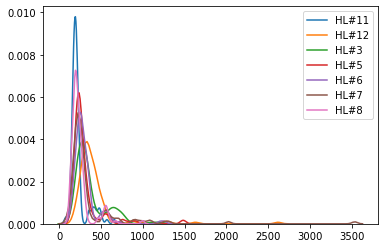

In [7]:
for name, data in nuclei.groupby('sample'):
    sns.kdeplot(data['volume'], label=name)
plt.show()

## Estimating the modes for each sample

In [8]:
modes = nuclei.groupby('sample').apply(lambda data: calc_mode(data['volume']))
modes.name = 'mode'
modes

sample
HL#11    193.521886
HL#12    349.575524
HL#3     278.756913
HL#5     243.020037
HL#6     259.858582
HL#7     237.605951
HL#8     205.946163
Name: mode, dtype: float64

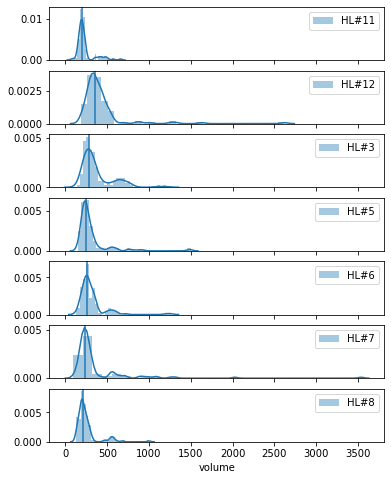

In [9]:
groupby = nuclei.groupby('sample')
fig, axs = plt.subplots(len(groupby), sharex=True, figsize=(6,8))
for (name, data), ax in zip(nuclei.groupby('sample'), axs):
    sns.distplot(data['volume'], label=name, bins=30, ax=ax, axlabel='')
    ax.axvline(calc_mode(data['volume']))
    ax.legend()

ax.set_xlabel('volume')
plt.show()

In [10]:
nuclei = nuclei.join(modes, on='sample')

In [11]:
nuclei['normalised_volume'] = nuclei['volume'] / nuclei['mode']

In [12]:
nuclei['normalised_volume'].describe()

count    913.000000
mean       1.268407
std        0.890793
min        0.380433
25%        0.887760
50%        1.035654
75%        1.277010
max       14.877389
Name: normalised_volume, dtype: float64

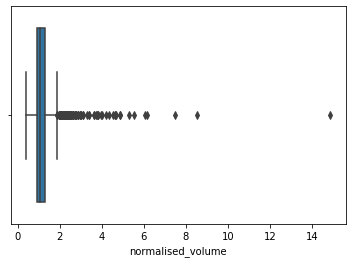

In [13]:
sns.boxplot(nuclei['normalised_volume'])

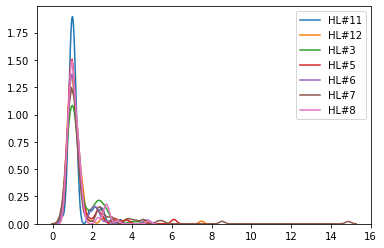

In [14]:
for name, data in nuclei.groupby('sample'):
    sns.kdeplot(data['normalised_volume'], label=name)
plt.show()

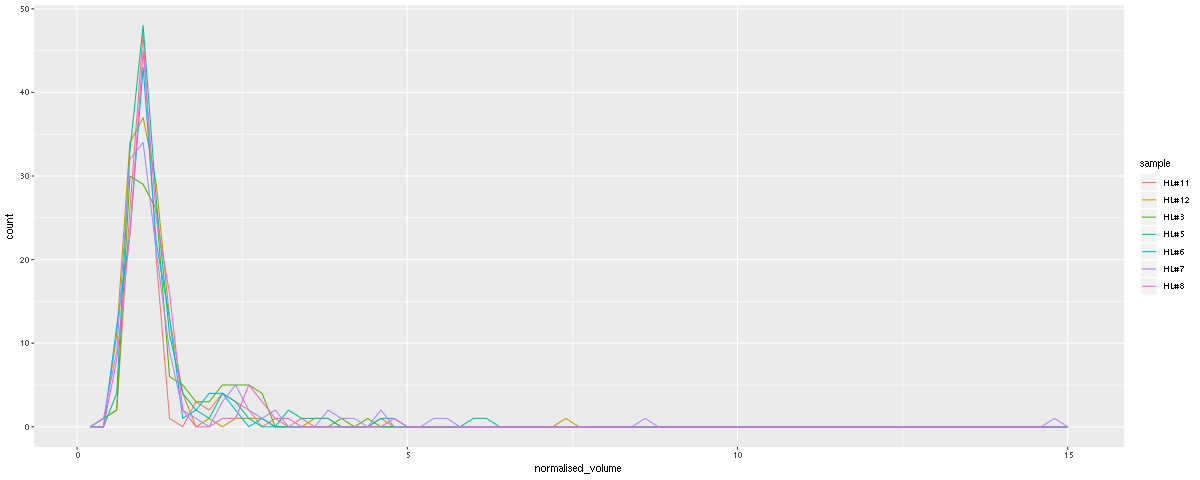

In [15]:
%%R -i nuclei -w 1200
ggplot(nuclei, aes(x=normalised_volume, color=sample)) + geom_freqpoly(binwidth=0.2)

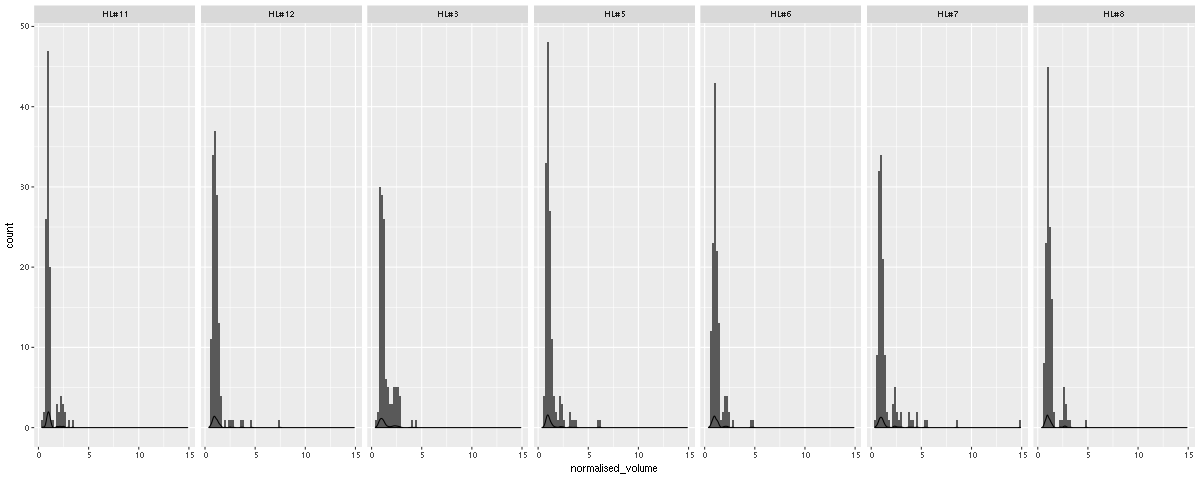

In [16]:
%%R -i nuclei -w 1200
ggplot(nuclei, aes(x=normalised_volume)) + geom_histogram(binwidth=0.2) + geom_density() + facet_wrap( ~ sample, ncol=7)

## Outliers

In [17]:
outlier_threshold = 6.0
print(f"About {(nuclei['normalised_volume'] >= outlier_threshold).sum() / len(nuclei) * 100:.2f}% of nuclei have a ploidy > 8n")

About 0.55% of nuclei have a ploidy > 8n


In [18]:
# nuclei = nuclei[nuclei['normalised_volume'] < outlier_threshold]

## Estimating ploidy fractions

### Threshold-based approach

Text(8, 1.6, '>8n')

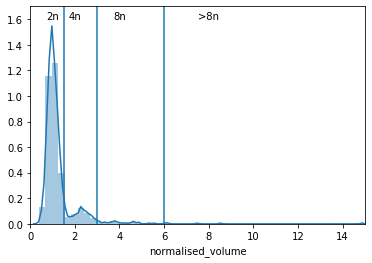

In [19]:
sns.distplot(nuclei['normalised_volume'])
threshold_2n = 1.5
threshold_4n = 3
threshold_8n = 6
plt.axvline(threshold_2n)
plt.axvline(threshold_4n)
plt.axvline(threshold_8n)
plt.xlim(0, 15)
plt.ylim(0, 1.7)
plt.text(1, 1.6, "2n", horizontalalignment='center')
plt.text(2, 1.6, "4n", horizontalalignment='center')
plt.text(4, 1.6, "8n", horizontalalignment='center')
plt.text(8, 1.6, ">8n", horizontalalignment='center')

In [20]:
nuclei['ploidy'] = ['2n' if nv < threshold_2n else ('4n' if nv < threshold_4n else ('8n' if nv < threshold_8n else '16n')) for nv in nuclei['normalised_volume']]

In [21]:
nuclei.pivot(index = nuclei.groupby('sample').cumcount(), columns='sample').to_excel('../../../results/190925_ploidy_from_diameter_pivot.xlsx')

### Gaussian mixture with minuit

#### Combined fit

In [35]:
import iminuit
import probfit

In [36]:
gauss1 = probfit.rename(probfit.gaussian, ['x', 'mu1', 'sigma1'])
gauss2 = lambda x, mu2, sigma1, mu1: probfit.gaussian(x, mu2, mu2/mu1*sigma1)
gauss3 = lambda x, mu3, sigma1, mu1: probfit.gaussian(x, mu3, mu3/mu1*sigma1)
pdf = probfit.AddPdfNorm(gauss1, gauss2, gauss3, facname=['f1', 'f2'])

In [37]:
unbinned_likelihood = probfit.UnbinnedLH(pdf, nuclei['normalised_volume'].values)

In [38]:
pars = dict(mu1=1, mu2=2, mu3=4, sigma1=0.2, f1=0.9, f2=0.08,
           error_mu1=0.1, error_mu2=0.1, error_mu3=0.1, 
            error_sigma1=0.1, 
           error_f1=0.1, error_f2=0.01)

In [39]:
minuit_combined = iminuit.Minuit(unbinned_likelihood, 
                                 fix_mu1=True, pedantic=False,
                                 **pars)
_ = minuit_combined.migrad()

FCN = 441.96539146382554 
 TOTAL NCALL = 195 
 NCALLS = 195 
 
 
 EDM = 8.349874449146218e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu1,1,0.1,,,,,Yes
1,sigma1,0.223545,0.00567314,,,,,No
2,mu2,2.38308,0.0659977,,,,,No
3,mu3,6.56461,0.429538,,,,,No
4,f1,0.854847,0.0128512,,,,,No
5,f2,0.126589,0.012241,,,,,No


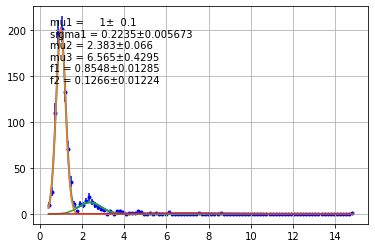

In [60]:
unbinned_likelihood.draw(minuit_combined, parts=True);

Thresholds from combined fit:

In [51]:
sp.optimize.fsolve(
    lambda x: (minuit_combined.values['f1'] * gauss1(x, minuit_combined.values['mu1'], minuit_combined.values['sigma1']) 
               - minuit_combined.values['f2'] * gauss2(x, minuit_combined.values['mu2'], minuit_combined.values['sigma1'], minuit_combined.values['mu1'])
              ),
1.5)

array([1.6172226])

In [52]:
sp.optimize.fsolve(
    lambda x: (minuit_combined.values['f2'] * gauss2(x, minuit_combined.values['mu2'], minuit_combined.values['sigma1'], minuit_combined.values['mu1'])
               - (1-minuit_combined.values['f1']-minuit_combined.values['f2']) * gauss3(x, minuit_combined.values['mu3'], minuit_combined.values['sigma1'], minuit_combined.values['mu1'])
              ),
3)

array([3.97869947])

### Simultanious fit with fixed means

In [43]:
simultaneous_likelihood = probfit.SimultaneousFit(
    *[probfit.UnbinnedLH(
        probfit.rename(
            pdf,
            ['x', 'mu1', 'sigma1', 'mu2', 'mu3', f'f1_{name}', f'f2_{name}']
        ),
        data['normalised_volume'].values
    ) 
      for name, data in nuclei.groupby('sample')])

In [44]:
pars_sim = dict(mu1=1, 
                mu2=2,#minuit_combined.values['mu2'], 
                mu3=4,#minuit_combined.values['mu3'], 
                sigma1=minuit_combined.values['sigma1'],
#                 sigma2=minuit_combined.values['sigma2'],
#                 sigma3=minuit_combined.values['sigma3'],
           error_mu1=0.1, error_mu2=0.1, error_mu3=0.1, 
            error_sigma1=0.1)
for name in nuclei['sample'].unique():
    pars_sim[f'f1_{name}'] = minuit_combined.values['f1']
    pars_sim[f'error_f1_{name}'] = 0.001
    pars_sim[f'f2_{name}'] = minuit_combined.values['f2']
    pars_sim[f'error_f2_{name}'] = 0.001
    pars_sim[f'limit_f1_{name}'] = (0, 1)
    pars_sim[f'limit_f2_{name}'] = (0, 1)

In [45]:
minuit_sim = iminuit.Minuit(simultaneous_likelihood, errordef=0.5, **pars_sim,
                            fix_mu1=True, fix_mu2=True, fix_mu3=True
                           )

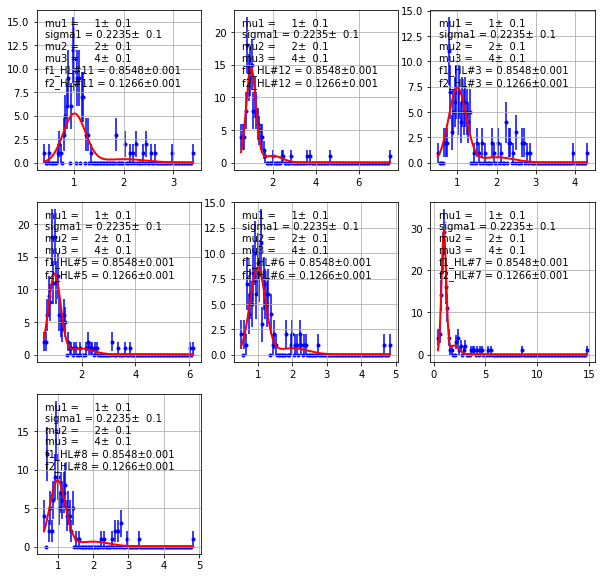

In [46]:
plt.figure(figsize=(10,10))
simultaneous_likelihood.draw(minuit_sim);

In [47]:
minuit_sim.migrad();

FCN = 482.122694476132 
 TOTAL NCALL = 1120 
 NCALLS = 1120 
 
 
 EDM = 2.7849526624075396e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu1,1,0.1,,,,,Yes
1,sigma1,0.244439,0.00640108,,,,,No
2,mu2,2,0.1,,,,,Yes
3,mu3,4,0.1,,,,,Yes
4,f1_HL#11,0.846356,0.0536584,,,0,1,No
5,f2_HL#11,0.147737,0.0549995,,,0,1,No
6,f1_HL#12,0.92753,0.0257842,,,0,1,No
7,f2_HL#12,0.0350174,0.0228239,,,0,1,No
8,f1_HL#3,0.735358,0.0505139,,,0,1,No
9,f2_HL#3,0.244646,0.0501918,,,0,1,No


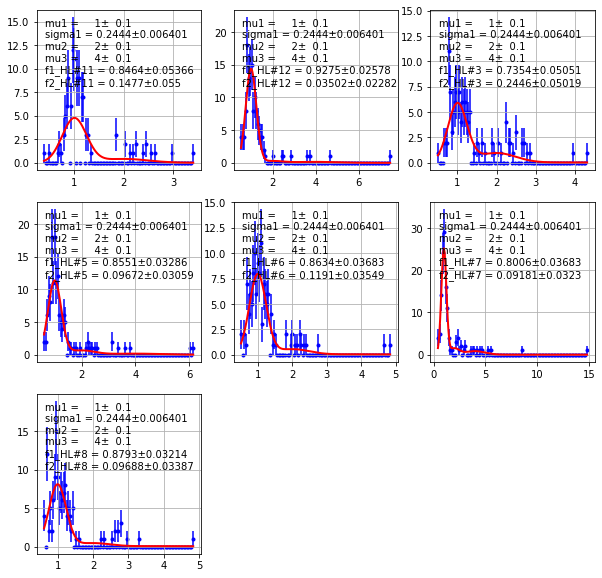

In [48]:
plt.figure(figsize=(10,10))
simultaneous_likelihood.draw(minuit_sim);

In [137]:
p = pd.DataFrame([dict(minuit_sim.values), dict(minuit_sim.errors)], index=['fraction', 'error']).T
p = p[p.index.str.startswith('f')]
p['ploidy'] = [f'{2*int(x[1])}n' for x in p.index]
p['sample'] = [x[3:] for x in p.index]
p = p.reset_index(drop=True)
p = p.pivot(index='sample', columns='ploidy').sort_index(axis='columns', sort_remaining=False, level=1).swaplevel(axis='columns')
# p[('8n', 'fraction')] = 1 - p[('2n', 'fraction')] - p[('4n', 'fraction')]
# p[('8n', 'error')] = p[('2n', 'error')] + p[('4n', 'error')]
p.to_excel('../../../results/ploidy_levels_gauss_mixture.xlsx')
p

ploidy        2n                  4n          
        fraction     error  fraction     error
sample                                        
HL#11   0.846356  0.053658  0.147737  0.055000
HL#12   0.927530  0.025784  0.035017  0.022824
HL#3    0.735358  0.050514  0.244646  0.050192
HL#5    0.855076  0.032859  0.096715  0.030585
HL#6    0.863356  0.036832  0.119061  0.035494
HL#7    0.800600  0.036830  0.091814  0.032295
HL#8    0.879257  0.032141  0.096879  0.033874